<a href="https://colab.research.google.com/github/EnsarIshakoglu/NLP/blob/trash-acc-but-good-loss-multiple-categories/NLP_Text_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Source: https://keras.io/examples/nlp/multi_label_classification/#introduction
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf
from ast import literal_eval

# Tensorflow
import tensorflow as tf
!pip install tensorflow_addons
import tensorflow_addons as tfa

# Keras
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential, Input
from keras.layers import Dense, Conv1D, SeparableConv1D, BatchNormalization, MaxPool1D, Dropout, Flatten, Embedding

# SKlearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from imblearn.over_sampling import SMOTE

# Data processing
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# NLTK
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

# Stackapi to fetch stackoverflow api
!pip install stackapi
from stackapi import StackAPI

     |████████████████████████████████| 1.1 MB 5.2 MB/s 
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
  Created wheel for stackapi: filename=StackAPI-0.2.0-py3-none-any.whl size=5856 sha256=d2f1bb630ed16e80b8935359bd226196696da101ad843d4c1448b817f52f8edb
  Stored in directory: /root/.cache/pip/wheels/ec/db/60/df42a65853e3581c26a2fbb2012a228cb8e267369a3b9ca44d
Successfully built stackapi


### Mount colab drive to google drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Fetch data

In [4]:
# Get the data from stackoverflow sorted by votes
def fetch_data():
  if not exists('/content/NLP-question-data'):
    !git clone https://github.com/EnsarIshakoglu/NLP-question-data.git
  
  data = pd.read_csv('/content/NLP-question-data/questions.csv')
  return data

## Remove useless data

In [5]:
def clean_data(df):  
  df = df[['tags', 'body']]

  # Strip html tags with regex:
  df['body'] = df['body'].str.replace(r'<[^<>]*>', '', regex=True)

  # Get first tag for multi-class classification
  row_count = df.shape[0]

  # for i in range(row_count):
  #   df['tags'].iloc[i] = df['tags'].iloc[i][0]
  
  return df

### Create folder and file from df, unmout drive after

In [6]:
from os.path import exists

!mkdir stackoverflow

if not exists('/content/stackoverflow/questions.csv') or not exists('/content/NLP-question-data'):
  df = fetch_data()[['tags', 'body']]
  df = clean_data(df)
  df.to_csv('/content/stackoverflow/questions.csv')
  print("Fetched data from stackoverflow, removed the useless data and saved it in stackoverflow/questions.csv")

drive.flush_and_unmount()
df

Cloning into 'NLP-question-data'...
remote: Enumerating objects: 15, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 15 (delta 2), reused 10 (delta 0), pack-reused 0
Unpacking objects: 100% (15/15), done.
Fetched data from stackoverflow, removed the useless data and saved it in stackoverflow/questions.csv


,tags,body
0,"['java', 'c++', 'performance', 'cpu-architectu...",Here is a piece of C++ code that shows some ve...
1,"['git', 'version-control', 'git-commit', 'undo']",I accidentally committed the wrong files to Gi...
2,"['git', 'version-control', 'git-branch', 'git-...",I want to delete a branch both locally and rem...
3,"['git', 'version-control', 'git-pull', 'git-fe...",What are the differences between git pull and ...
4,"['python', 'iterator', 'generator', 'yield', '...",What is the use of the yield keyword in Python...
...,...,...
17495,"['python', 'pandas', 'dataframe', 'nan']",I have a Pandas Dataframe as below:\n itm...
17496,"['java', 'datetime', 'java-8', 'java-time']",What is the best way to convert a java.util.Da...
17497,['visual-studio-code'],Is there a Compare feature like the Plugin for...
17498,"['visual-studio-code', 'whitespace', 'vscode-s...","Is it possible to show whitespace characters, ..."


### Load file from drive

In [7]:
print(f"There are {len(df['body'].unique())} rows in the dataset.")

There are 3900 rows in the dataset.


In [8]:
# df = df[~df['body'].duplicated()]
# print(f"There are {len(df)} rows in the deduplicated dataset.")

In [9]:
# There are a lot of terms with occurrence below 20.
threshold = 5

print(sum(df['tags'].value_counts() < threshold))

# How many unique terms?
print(df['tags'].nunique())

645
3318


In [10]:
# Filtering the rare terms because there is not enough data to train properly with.
df_filtered = df.groupby("tags").filter(lambda x: len(x) > threshold)
df_filtered

,tags,body
7,"['javascript', 'arrays']",I have an array of numbers and I'm using the ....
21,"['git', 'branch', 'git-branch']",How do you delete untracked local files from y...
39,"['git', 'git-branch', 'branching-and-merging']",I'd like to move the last several commits I've...
45,"['git', 'version-control']",How do I discard changes in my working copy th...
54,"['javascript', 'string', 'replace']",I have this string in my JavaScript code:\n&qu...
...,...,...
17491,"['git', 'version-control']",Can someone tell me the difference between HEA...
17492,"['html', 'css']",Is the property text-align: center; a good way...
17495,"['python', 'pandas', 'dataframe', 'nan']",I have a Pandas Dataframe as below:\n itm...
17497,['visual-studio-code'],Is there a Compare feature like the Plugin for...


In [11]:
# Remove punctuation
df_filtered['body'] = df_filtered['body'].replace('[^\w\s]','', regex=True)
df_filtered['body'] = df_filtered['body'].replace(r'\s+|\\n', ' ', regex=True) 
    
df_filtered

,tags,body
7,"['javascript', 'arrays']",I have an array of numbers and Im using the pu...
21,"['git', 'branch', 'git-branch']",How do you delete untracked local files from y...
39,"['git', 'git-branch', 'branching-and-merging']",Id like to move the last several commits Ive c...
45,"['git', 'version-control']",How do I discard changes in my working copy th...
54,"['javascript', 'string', 'replace']",I have this string in my JavaScript code quotT...
...,...,...
17491,"['git', 'version-control']",Can someone tell me the difference between HEA...
17492,"['html', 'css']",Is the property textalign center a good way to...
17495,"['python', 'pandas', 'dataframe', 'nan']",I have a Pandas Dataframe as below itm Date Am...
17497,['visual-studio-code'],Is there a Compare feature like the Plugin for...


In [12]:
# Source: https://stackoverflow.com/questions/29523254/python-remove-stop-words-from-pandas-dataframe

stop = stopwords.words('english')

# Exclude stopwords with Python's list comprehension and pandas.DataFrame.apply.
df_filtered['body'] = df_filtered['body'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
df_filtered.head()

,tags,body
7,"['javascript', 'arrays']",I array numbers Im using push method add eleme...
21,"['git', 'branch', 'git-branch']",How delete untracked local files current worki...
39,"['git', 'git-branch', 'branching-and-merging']",Id like move last several commits Ive committe...
45,"['git', 'version-control']",How I discard changes working copy index
54,"['javascript', 'string', 'replace']",I string JavaScript code quotTest abc test tes...


In [13]:
# Source: https://www.machinelearningplus.com/nlp/lemmatization-examples-python/
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

# Lemmatize words
lemmatizer = WordNetLemmatizer()
df_filtered['body'] = df_filtered['body'].apply(
    lambda x: ' '.join([lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in x.split()]))
df_filtered.head()

,tags,body
7,"['javascript', 'arrays']",I array number Im use push method add element ...
21,"['git', 'branch', 'git-branch']",How delete untracked local file current work tree
39,"['git', 'git-branch', 'branching-and-merging']",Id like move last several commits Ive commit m...
45,"['git', 'version-control']",How I discard change work copy index
54,"['javascript', 'string', 'replace']",I string JavaScript code quotTest abc test tes...


In [14]:
# Check class imbalance:
print(df_filtered.groupby(df_filtered['tags']).size())

tags
['android', 'android-context']                        9
['android', 'android-intent', 'android-activity']    12
['android', 'android-intent']                        10
['android', 'android-layout']                        15
['android', 'android-viewpager']                     10
                                                     ..
['vim', 'vi']                                        21
['vim']                                              10
['visual-studio']                                    20
['visual-studio-code', 'vscode-settings']            20
['visual-studio-code']                               50
Length: 202, dtype: int64


## Prepare data

In [15]:
df_filtered['label'] = pd.factorize(df_filtered['tags'])[0]
df_filtered

,tags,body,label
7,"['javascript', 'arrays']",I array number Im use push method add element ...,0
21,"['git', 'branch', 'git-branch']",How delete untracked local file current work tree,1
39,"['git', 'git-branch', 'branching-and-merging']",Id like move last several commits Ive commit m...,2
45,"['git', 'version-control']",How I discard change work copy index,3
54,"['javascript', 'string', 'replace']",I string JavaScript code quotTest abc test tes...,4
...,...,...,...
17491,"['git', 'version-control']",Can someone tell difference HEAD work tree ind...,3
17492,"['html', 'css']",Is property textalign center good way center i...,29
17495,"['python', 'pandas', 'dataframe', 'nan']",I Pandas Dataframe itm Date Amount 67 420 2012...,134
17497,['visual-studio-code'],Is Compare feature like Plugin Notepad,93


In [16]:
vectorizer = CountVectorizer(min_df=0, lowercase=False)
vectorizer.fit(df_filtered['body'])
vectorizer.transform(df_filtered['body']).toarray()

array([[ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       ...,
       [ 0, 11,  0, ...,  1,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]])

In [17]:
# Use stratified splits because of class imbalance
X = df_filtered['body']
y = df_filtered['label']

# Initial train and test split.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=132)

# Splitting the test set further into validation and new test sets.
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=23)

print(f"Number of rows in training set: {len(X_train)}")
print(f"Number of rows in validation set: {len(X_val)}")
print(f"Number of rows in test set: {len(X_test)}")

Number of rows in training set: 2842
Number of rows in validation set: 356
Number of rows in test set: 355


In [18]:
X_train = vectorizer.transform(X_train)
X_test = vectorizer.transform(X_test)
X_val = vectorizer.transform(X_val)

In [19]:
# Dataset preview
print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'X_val shape: {X_val.shape}')
print(f'y_train shape: {y_train.shape}')

X_train shape: (2842, 5939)
X_test shape: (355, 5939)
X_val shape: (356, 5939)
y_train shape: (2842,)


In [20]:
y_train.shape

(2842,)

## Create model

In [21]:
# Amount of columns in data:
input_dim = X_train.shape[1]

# Amount of unique labels:
output_dim = y_train.nunique()

print(f'Input dim: {input_dim}')
print(f'Output dim: {output_dim}')

Input dim: 5939
Output dim: 202


In [22]:
# Reshape labels
label_encoder = LabelEncoder()
y_train = np.array(label_encoder.fit_transform(y_train))
y_val = np.array(label_encoder.fit_transform(y_val))
y_test = np.array(label_encoder.fit_transform(y_test))

y_train = tf.one_hot(y_train, depth=output_dim)
y_val = tf.one_hot(y_val, depth=output_dim)
y_test = tf.one_hot(y_test, depth=output_dim)

In [23]:
# First define baseline model. Then use it in Keras Classifier for the training
def baseline_model():
    # Create model here
    model = Sequential()
    model.add(Dense(128, input_dim = input_dim, activation = 'relu')) # Rectified Linear Unit Activation Function
    model.add(Dense(64, activation = 'relu'))
    model.add(Dense(32, activation = 'relu'))

    model.add(Dense(output_dim, activation = 'softmax')) # Softmax for multi-class classification
    # Compile model here
    model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    return model

## Evaluate model

In [24]:
model = baseline_model()

model.compile(
    loss="binary_crossentropy", optimizer="adam", metrics=["categorical_accuracy"]
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               760320    
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 202)               6666      
                                                                 
Total params: 777,322
Trainable params: 777,322
Non-trainable params: 0
_________________________________________________________________


In [25]:
# For Keras, convert dataframe to array values (Inbuilt requirement of Keras)
X = X_train
y = y_train

Epoch 1/8


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:450: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Reshape:0", shape=(None, 128), dtype=float32), dense_shape=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


23/23 [==============================] - 2s 24ms/step - loss: 0.6255 - categorical_accuracy: 0.0039 - val_loss: 0.4168 - val_categorical_accuracy: 0.0000e+00
Epoch 2/8
23/23 [==============================] - 0s 16ms/step - loss: 0.1896 - categorical_accuracy: 0.0025 - val_loss: 0.0631 - val_categorical_accuracy: 0.0000e+00
Epoch 3/8
23/23 [==============================] - 0s 16ms/step - loss: 0.0561 - categorical_accuracy: 0.0669 - val_loss: 0.0544 - val_categorical_accuracy: 0.0056
Epoch 4/8
23/23 [==============================] - 0s 15ms/step - loss: 0.0447 - categorical_accuracy: 0.0823 - val_loss: 0.0464 - val_categorical_accuracy: 0.0056
Epoch 5/8
23/23 [==============================] - 0s 16ms/step - loss: 0.0379 - categorical_accuracy: 0.0823 - val_loss: 0.0405 - val_categorical_accuracy: 0.0056
Epoch 6/8
23/23 [==============================] - 0s 15ms/step - loss: 0.0330 - categorical_accuracy: 0.0827 - val_loss: 0.0367 - val_categorical_accuracy: 0.0056
Epoch 7/8
23/23 [=

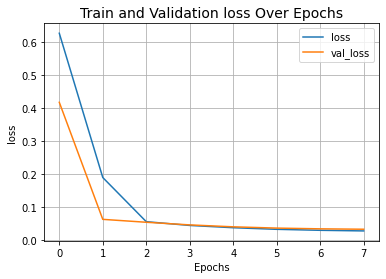

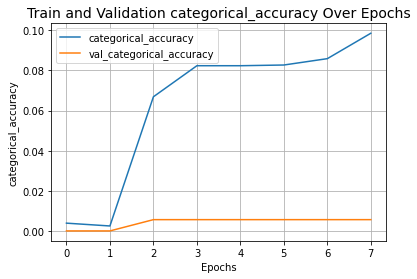

In [26]:
history = model.fit(X, y, validation_data=[X_val, y_val], batch_size = 128, epochs = 8, verbose = 1)

def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_result("loss")
plot_result("categorical_accuracy")

In [27]:
_, categorical_acc = model.evaluate(X_test, y_test)
print(f"Categorical accuracy on the test set: {round(categorical_acc * 100, 2)}%.")

12/12 [==============================] - 0s 3ms/step - loss: 0.0340 - categorical_accuracy: 0.0056
Categorical accuracy on the test set: 0.56%.


In [29]:
# Get predictions
predictions = model.predict(X_test)
predictions

array([[0.07930826, 0.00194095, 0.00049578, ..., 0.00110256, 0.0012321 ,
        0.00033328],
       [0.02128668, 0.0050739 , 0.00093104, ..., 0.00232497, 0.00150922,
        0.00051122],
       [0.0155537 , 0.00196345, 0.00031681, ..., 0.000757  , 0.00045067,
        0.00015102],
       ...,
       [0.03535331, 0.00300414, 0.00071918, ..., 0.0015924 , 0.00219468,
        0.00060226],
       [0.02809513, 0.00250736, 0.00087021, ..., 0.00178855, 0.00096876,
        0.00049142],
       [0.01128561, 0.00255827, 0.00044371, ..., 0.00091206, 0.0004657 ,
        0.00019646]], dtype=float32)